In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.interpolate as intp
from IPython.display import display
from IPython.display import clear_output

def marginals(x):
    return np.append(x.sum(axis=1),x.sum(axis=0))

def clip(x):
    #returns x, clipped to be between -1 and 1
    for idx in range(len(x)):
        if x[idx] > 1:
            x[idx] = 1
        elif x[idx] < -1:
            x[idx] = -1
    return x

def AWR_round(X,b):
    #round an approximate transport map to feasible via algorithm of [AWR17]
    v = np.minimum(b[:n]/(X@np.ones(n)),  np.ones(n)); X = np.diag(v) @ X
    u = np.minimum(b[n:]/(X.T@np.ones(n)),np.ones(n)); X = X @ np.diag(u)
    v = (b-marginals(X)); er = v[:n]; ec = v[n:]
    return  X + np.outer(er,ec)/(er.sum())


def AWR_round_impl(M,lscale, rscale, b):
    #implicit formulation of above: given map of form lscale * X * rscale, computes modified scaling factors 
    #and rank 1 matrix to exactly satisfy marginals
    v = np.minimum(b[:n]/(lscale*(M@rscale)),  np.ones(n)); 
    lscale = lscale*v
    u = np.minimum(b[n:]/(rscale*(M.T@lscale)),np.ones(n)); 
    rscale = rscale*u
    margi = np.append(lscale*(M@rscale), rscale*(M.T@lscale))
    s = (b-margi); er = s[:n]; ec = s[n:]
    return  lscale,rscale, er/er.sum(), ec # lscale * M * rscale + er ec^T is a transport map for b

def entropy(X,threshhold=1e-18):
    return np.sum(X*np.log(X+threshhold))

In [2]:
import pandas as pd
df = pd.read_csv('mnist_test.csv').sort_values(by=['7']).reset_index().drop(['index'],axis=1)
ar = df['7'].to_numpy()
counts = np.zeros(11)
for i in range(10):
    counts[i+1] =  counts[i] + ar[ar == i].shape[0]
    
def mnist_instance(df,counts,rng,i):
    #generates an OT instance corresponding to two randomly chosen digits from MNIST with label i
    n = 28
    x1 = rng.integers(counts[i],counts[i+1])
    x2 = rng.integers(counts[i],counts[i+1])
    p = df.iloc[x1,1:].to_numpy(); p = p/p.sum()
    q = df.iloc[x2,1:].to_numpy(); q = q/q.sum()
    b = np.append(p,q)
    b += 1/(n**6); b = 2*b/b.sum()
    C = np.zeros((n**2,n**2))
    for i1 in range(n):
        for i2 in range(n):
            for j1 in range(n):
                for j2 in range(n):
                    C[n*i1+i2,n*j1+j2] = (i1-j1)**2 + (i2-j2)**2
    return b, C/(C.max())

def sinkhorn_track_progress(M,r,c,T,reg):
    alpha = np.zeros(n); beta = np.zeros(n)
    u,v = np.ones(n)/n, np.ones(n)/n
    scaling_ub = 1e15
    def get_K(alpha, beta):
        return np.exp(-(M - alpha.reshape((-1, 1))
                        - beta.reshape((1, -1))) / reg)
    
    def form_tpm(alpha, beta, u, v):
        return np.exp(-(M - alpha.reshape((-1, 1)) - beta.reshape((1, -1)))
                      / reg + np.log(u.reshape((-1, 1))) + np.log(v.reshape((1, -1))))
    
    K = get_K(alpha,beta)
    std_obj = []; entropy_obj = []; 
    for i in range(T): 
        u = r/(K@v); v = c/(K.T@u);
        if abs(u).max() > scaling_ub or abs(v).max() > scaling_ub: #if entries of u,v are too large
            alpha,beta = alpha + reg * np.log(u), beta + reg * np.log(v)
            u,v = np.ones(n)/n, np.ones(n)/n
            K = get_K(alpha,beta) #recompute transport map prescaled by alpha, beta
        if i%25 == 0:
            X = form_tpm(alpha,beta,u,v); Xr = AWR_round(X, np.append(r,c)); 
            std_obj.append(np.sum(Xr*M))
            entropy_obj.append(np.sum(Xr*M) + mu*entropy(Xr))
    return std_obj, entropy_obj

In [3]:
def sinkhorn_getbaseline(M,r,c,T,reg):
    alpha = np.zeros(n); beta = np.zeros(n) #checkpoint for scalings; this helps numerical stability
    u,v = np.ones(n)/n, np.ones(n)/n
    scaling_ub = 1e15
    def get_K(alpha, beta):
        return np.exp(-(M - alpha.reshape((-1, 1))
                        - beta.reshape((1, -1))) / reg)
    
    def form_tpm(alpha, beta, u, v):
        return np.exp(-(M - alpha.reshape((-1, 1)) - beta.reshape((1, -1)))
                      / reg + np.log(u.reshape((-1, 1))) + np.log(v.reshape((1, -1))))
    
    K = get_K(alpha,beta)
    for i in range(T): 
        u = r/(K@v); v = c/(K.T@u);
        if abs(u).max() > scaling_ub or abs(v).max() > scaling_ub: #if entries of u,v are too large
            alpha,beta = alpha + reg * np.log(u), beta + reg * np.log(v)
            u,v = np.ones(n)/n, np.ones(n)/n
            K = get_K(alpha,beta) #recompute transport map prescaled by alpha, beta
    return form_tpm(alpha,beta,u,v), u*np.exp(alpha/reg), v*np.exp(beta/reg)

In [4]:
def prox(n,b,A_xbar,K,xbar,ybar,mu,tol,alpha=1.5,beta=0.7):
    x,y = xbar, ybar
    x_scaling = np.exp(xbar)
    A_x = A_xbar 
    
    k = 0
    while True:
        #y[k+1] responds to x[k]
        yp1 = clip((ybar*A_xbar/A_x) + (A_x-b)/(2*beta*A_x))
        
        #x[k+1] responds to y[k+1]
        xp1_update = (-yp1 - beta*yp1**2 + beta*ybar**2);
        xp1 = (alpha*xbar+xp1_update)/(alpha+mu); 
        xp1_scaling = np.exp(xp1)
        
        #compute row and column sums of x[k+1] transport map
        A_xrowsum = xp1_scaling[:n]*(K@xp1_scaling[n:]) 
        A_xcolsum = xp1_scaling[n:]*(K@xp1_scaling[:n])
        A_xp1 = np.append(A_xrowsum, A_xcolsum)
        
        #correct scalings to make transport map lie on simplex
        x_sum = A_xrowsum.sum() 
        A_xp1 /= x_sum
        xp1 -= np.log(x_sum)/2;
        
        k += 1
        if la.norm(yp1-y,1) < tol:
            yp1 = clip((ybar*A_xbar/A_xp1) + (A_xp1-b)/(2*beta*A_xp1))
            return xp1, yp1, k, A_xp1, ybar
        if k > 50:
            raise Exception("Alternating minimization failed to converge")
            
        #x[k], y[k] <- x[k+1], y[k+1]
        x,y = xp1, yp1
        x_scaling = xp1_scaling
        A_x = A_xp1

def sherman_proxpoint(b,C,T,mu,tolrate,x,alpha,beta):
    K = np.exp(-C/mu); n = b.shape[0]//2; KC = K*C
    xs = np.exp(x); y = np.zeros(2*n)
    A_xrowsum = xs[:n]*(K@xs[n:]); A_xcolsum = xs[n:]*(K@xs[:n]); 
    A_xbar = np.append(A_xrowsum, A_xcolsum); 
    x_sum = A_xrowsum.sum(); A_xbar /= x_sum; x -= np.log(x_sum)/2;
    prox_steps = 0; altmin_steps = 0
    best = 100; x_best, y_best = x,y
    
    obj_track = []
    altmin_track = []
    ent_track = []
    pdfe_track = []
    new_obj = 10
    
    while altmin_steps < T:
        x, y, k, A_xbar, ybar = prox(n,b,A_xbar,K,x,y,mu,tolrate/(i+1)**2,alpha,beta)
        xs = np.exp(x);
        lscale, rscale, er, ec = AWR_round_impl(K,xs[:n],xs[n:],b)
        new_obj = lscale @ KC @ rscale + er @ C @ ec     
        altmin_steps += k; prox_steps +=1;
        altmin_track.append(altmin_steps)
        obj_track.append(new_obj) 
        ent_track.append((x[:n]*lscale)@(K @ rscale)*mu+ (rscale*x[n:])@(K.T@lscale)*mu)
        pdfe_track.append(xs[:n]@KC@xs[n:] +
                          np.dot(xs[:n]*y[:n],(K@xs[n:])) + np.dot(xs[n:]*y[n:],(K@xs[:n])) 
                          - np.dot(y,b))
    return altmin_track, np.array(obj_track), np.array(ent_track), np.array(pdfe_track)

In [5]:
mu = 1/10
mu_OPT = []; 
mu_ENT = []
n=784; q=1
problems = [79543, 893654, 439093, 901514, 892506, 213308, 730353, 857810, 248698, 639250, 941094, 848481, 225911, 438703, 656015, 472702, 464413, 330074, 291973, 67746]
digit = [0, 8, 2, 9, 0, 0, 5, 3, 8, 5, 9, 0, 4, 0, 0, 7, 4, 1, 7, 7]

i_disp = display(f"Iteration number: {0}",display_id=True)
for idx in range(q):
    rng = np.random.default_rng(problems[idx])
    b, C = mnist_instance(df,counts,rng,digit[idx])
    X,_,_ = sinkhorn_getbaseline(C,b[:n], b[n:],4000,mu)
    i_disp.update(f"Iteration number: {idx}")
    if la.norm(marginals(X)-b,1) > 1e-13: 
        print("Warning on iteration ", idx)
    Xr = AWR_round(X,b)
    mu_OPT.append(np.sum(Xr*C))
    mu_ENT.append(np.sum(Xr*C) + mu*entropy(Xr))
    
mu_sink_track = [];
i_disp = display(f"Iteration number: {0}",display_id=True)
for idx in range(q):
    rng = np.random.default_rng(problems[idx])
    b, C = mnist_instance(df,counts,rng,digit[idx])
    i_disp.update(f"Iteration number: {idx+1}")
    mu_sink_track.append(sinkhorn_track_progress(C,b[:n], b[n:],1000,mu))

    
mu_proxpoint_track = []; 
n=784
problems = [79543, 893654, 439093, 901514, 892506, 213308, 730353, 857810, 248698, 639250, 941094, 848481, 225911, 438703, 656015, 472702, 464413, 330074, 291973, 67746]
digit = [0, 8, 2, 9, 0, 0, 5, 3, 8, 5, 9, 0, 4, 0, 0, 7, 4, 1, 7, 7]
i_disp = display(f"Iteration number: {0}",display_id=True)
for idx in range(q):
    rng = np.random.default_rng(problems[idx])
    b, C = mnist_instance(df,counts,rng,digit[idx])
    i_disp.update(f"Iteration number: {idx+1}")
    mu_proxpoint_track.append(sherman_proxpoint(b,C,1100,mu,1e4,np.zeros(2*n),2,1))

'Iteration number: 0'

'Iteration number: 1'

'Iteration number: 1'

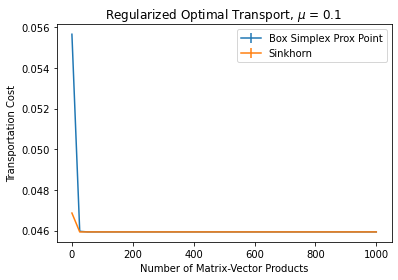

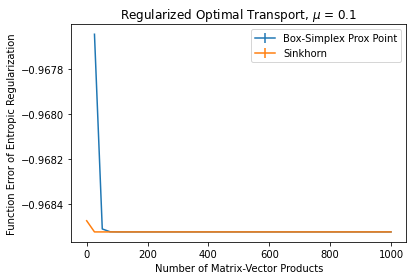

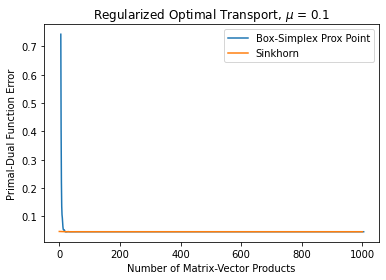

In [6]:
sink_obj_arr = np.zeros((q,40)); muOPT_avg = 0 
for i in range(q):
    sink_obj_arr[i,:] = np.array(mu_sink_track[i][0] - mu_OPT[i])
    muOPT_avg += mu_OPT[i]/q
 
    
testpts = np.linspace(5,1005,40)
interp_fe = np.zeros(40)
fe_all = np.ones((q,40))
for i in range(q):
    p_it, p_fn,_,_ = mu_proxpoint_track[i]; p_fn = np.array(p_fn) - mu_OPT[i];
    f = intp.interp1d(p_it, p_fn)
    interp_fe += f(testpts)/q + mu_OPT[i]/q
    fe_all[i,:] = f(testpts)

plt.errorbar(np.linspace(0,1000,40), muOPT_avg+np.mean(fe_all,axis=0),yerr= np.std(fe_all,axis=0))
plt.errorbar(np.linspace(0,1000,40),muOPT_avg+np.mean(sink_obj_arr,axis=0),yerr= np.std(sink_obj_arr,axis=0))
plt.legend(["Box Simplex Prox Point",'Sinkhorn'])
plt.xlabel("Number of Matrix-Vector Products")
plt.ylabel("Transportation Cost")
plt.title(f"Regularized Optimal Transport, $\mu$ = {mu}")
plt.show()

sink_obj_arr = np.zeros((q,40)); muENT_avg=0
for i in range(q):
    sink_obj_arr[i,:] = np.array(mu_sink_track[i][1]) - mu_ENT[i]
    muENT_avg += mu_ENT[i]/q
    
testpts = np.linspace(5,1005,40)
interp_fe = np.zeros(40)
fe_all = np.ones((q,40))
for i in range(q):
    p_it, _,p_en,_ = mu_proxpoint_track[i]; p_en = np.array(p_en) - mu_ENT[i]
    f = intp.interp1d(p_it, p_en)
    fe_all[i,:] = f(testpts)

plt.errorbar(np.linspace(0,1000,40)[1:], muENT_avg+np.mean(fe_all,axis=0)[1:],yerr= np.std(fe_all,axis=0)[1:])
plt.errorbar(np.linspace(0,1000,40),muENT_avg+np.mean(sink_obj_arr,axis=0),yerr= np.std(sink_obj_arr,axis=0))
plt.legend(["Box-Simplex Prox Point",'Sinkhorn'])
plt.xlabel("Number of Matrix-Vector Products")
plt.ylabel("Function Error of Entropic Regularization")
plt.title(f"Regularized Optimal Transport, $\mu$ = {mu}")
plt.show()

testpts = np.arange(5,1005)

pdfe = np.zeros(1000)
for i in range(q):
    p_it, _,_,p_pdfe = mu_proxpoint_track[i]; p_pdfe = np.array(p_pdfe)
    f = intp.interp1d(p_it, p_pdfe)
    pdfe += f(testpts)/q

sink_fe = np.zeros(40)
for i in range(q):
    sink_fe= sink_fe+ np.array(mu_sink_track[i][0])
    
plt.plot(testpts,pdfe)
plt.plot(np.linspace(0,1000,40), sink_fe/q)
plt.legend(["Box-Simplex Prox Point",'Sinkhorn'])
plt.xlabel("Number of Matrix-Vector Products")
plt.ylabel("Primal-Dual Function Error")
plt.title(f"Regularized Optimal Transport, $\mu$ = {mu}")
plt.show()